<a href="https://colab.research.google.com/github/srujayreddyv/CSC219-FP-MultiLabelTextClassification/blob/main/CSC219Team5_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 219- Machine Learning (Fall 2023)

# Final Project: Multi Label Text Classification using BERT

Team 5:
1. Alekya Paladugu
2. Samah Eltayeb
3. Srujay Reddy

## 1.0 INSTALLATIONS AND UPLOADING THE DATASET



In [1]:
!pip install scikit-multilearn
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.0 IMPORTS

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import sys
import copy
import time
import string
import warnings
from typing import Tuple, List
from functools import partial

import nltk
# nltk.download('reuters')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multioutput import ClassifierChain

import keras
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from tqdm import tqdm
import xgboost as xgb
from scipy.sparse import csr_matrix
from gensim.models import Word2Vec

import torch
from torch import optim
from torch import nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertPreTrainedModel

if not sys.warnoptions:
    warnings.simplefilter("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

stemmer = SnowballStemmer("english")

def plot_len_of_sentences(text_cols):
    comment_len = text_cols.len()
    # plot the distribution of comment lengths
    plt.figure(figsize=(8,4))
    sns.histplot(comment_len, kde=False, bins=50, color="red")
    plt.xlabel("Comment Length (Number of words)", fontsize=12)
    plt.ylabel("Number of Comments", fontsize=12)
    plt.title("Distribution of comment Lengths", fontsize=12)

    print("Average comment length:",int(sum(comment_len)/len(comment_len))," characters")

def plot_bar_graph(train_df,labels,title):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes([0,0,1,1])
    total_count = []
    for label in labels:
        total_count.append(len(train_df[train_df[label] == 1]))
    ax.bar(labels,total_count, color=['red', 'green', 'blue', 'purple', 'orange', 'yellow'])
    for i,data in enumerate(total_count):
        plt.text(i-.25,
                data/total_count[i]+100,
                total_count[i],
                fontsize=12)
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Number of comments')

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

def cleanPunc(sentence):
  #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

def lemmatize(sentence):
    lemmatizer = WordNetLemmatizer()
    lemSentence = ""
    for word in sentence.split():
        lem = lemmatizer.lemmatize(word)
        lemSentence += lem
        lemSentence += " "
    lemSentence = lemSentence.strip()
    return lemSentence

def preprocess_text(train_df):
    train_df['comment_text'] = train_df['comment_text'].str.lower()
    train_df['comment_text'] = train_df['comment_text'].apply(cleanHtml)
    train_df['comment_text'] = train_df['comment_text'].apply(cleanPunc)
    train_df['comment_text'] = train_df['comment_text'].apply(keepAlpha)
    train_df['comment_text'] = train_df['comment_text'].apply(removeStopWords)
    train_df['comment_text'] = train_df['comment_text'].apply(lemmatize)
    return train_df

def sample_dataset(train_df):
    df = train_df[train_df['clean']==0]
    df = df.append(train_df[train_df['clean']==1].sample(frac=1, random_state=200).iloc[:df.shape[0],:])
    df = df.sample(frac=1,random_state=200)
    return df

#ML preprocessing
def baseline_ml_preprocessing(X_train,X_test):
    word_vectorizer = TfidfVectorizer(
        strip_accents='unicode',
        analyzer='word',
        max_features=3000,
        token_pattern=r'\w{1,}',
        ngram_range=(1, 3),
        stop_words='english',
        sublinear_tf=True)

    word_vectorizer.fit(X_train)
    ml_X_train = word_vectorizer.transform(X_train)
    ml_X_test = word_vectorizer.transform(X_test)
    return ml_X_train, ml_X_test

def Sequential_Preprocessing(X_train, X_test, y_train, y_test,max_seq_len):
    tokenizer = Tokenizer(num_words=20000,oov_token='<UNK>')
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    X_train = torch.from_numpy(pad_sequences(X_train, maxlen=max_seq_len))
    X_test = torch.from_numpy(pad_sequences(X_test, maxlen=max_seq_len))

    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)

    return tokenizer, X_train, y_train, X_test, y_test

def create_glove_embedding_matrix(tokenizer, glove_file_path):
    glove_embeddings = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            glove_embeddings[word] = vector

    vocab_size = len(tokenizer.index_word) + 1
    #File 300 dim expected
    embedding_dim = 300
    glove_embedding_matrix = torch.zeros(vocab_size, embedding_dim)

    unknown_words = 0
    for i in range(1, vocab_size):
        word = tokenizer.index_word[i]
        if word in glove_embeddings.keys():
            glove_embedding_matrix[i] = torch.from_numpy(glove_embeddings[word]).float()
        else:
            unknown_words += 1

    print("GloVe embedding matrix created!")
    print('Vocabulary size: {}'.format(vocab_size))
    print('Total unknown words: {}'.format(unknown_words))

    return glove_embeddings, glove_embedding_matrix

def create_glove_label_embedding(labels, glove_embeddings):
    glove_label_embedding = torch.zeros(len(labels), 300)

    for index, label in enumerate(labels):
        wrds = label.split('_')
        for l in wrds:
            if l in glove_embeddings.keys():
                glove_label_embedding[index] += torch.from_numpy(glove_embeddings[l])
        glove_label_embedding[index] /= len(wrds)

    return glove_label_embedding

def get_bert_embedding_matrix(tokenizer):
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    vocab_size = len(tokenizer.index_word)+1
    bert_embedding_matrix = torch.zeros(vocab_size, 768)

    tokens_tensor=[]
    for i in tqdm(range(1, vocab_size)):
        word = tokenizer.index_word[i]
        tokens = bert_tokenizer.encode(word,add_special_tokens=False)[0]
        tokens_tensor.append(tokens)
    batch_size = 512
    vocab_batches = [tokens_tensor[i:i+batch_size] for i in range(0, len(tokens_tensor), batch_size)]

    with torch.no_grad():
      bert_embeddings = []
      for i in tqdm(range(len(vocab_batches))):
        batch = vocab_batches[i]
        inputs = {
        'input_ids': torch.tensor([batch]),
        'attention_mask': torch.ones(len(batch)).unsqueeze(0)
        }
        outputs = bert_model(**inputs)
        batch_embeddings = outputs[0][0]
        bert_embeddings.append(batch_embeddings)

    bert_embedding_matrix = torch.cat(bert_embeddings, dim=0)
    return bert_embedding_matrix

#Build adjacency matrix based on Co-Occurencies label
def create_adjacency_matrix_cooccurance(data_label):
  cooccur_matrix = np.zeros((data_label.shape[1], data_label.shape[1]), dtype=float)
  for y in data_label:
      y = list(y)
      for i in range(len(y)):
          for j in range(len(y)):
            #data_label
              if y[i] == 1 and y[j] == 1:
                  cooccur_matrix[i, j] += 1
  row_sums = data_label.sum(axis=0)

  for i in range(cooccur_matrix.shape[0]):
    for j in range(cooccur_matrix.shape[0]):
      if row_sums[i]!=0:
        cooccur_matrix[i][j]=cooccur_matrix[i,j]/row_sums[i]
      else:
        cooccur_matrix[i][j]=cooccur_matrix[i,j]

  return cooccur_matrix

def check_accuracy(model, label_embedding, X, y):
  model.eval()
  with torch.no_grad():
    out = model(X, label_embedding)
    y_pred = torch.sigmoid(out.detach()).round().cpu()
    f1score = f1_score(y, y_pred, average='micro')
    hammingloss = hamming_loss(y, y_pred)
  return hammingloss, f1score

class dataset(Dataset):
  def __init__(self, x, y):
    self.x  = x
    self.y = y
  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

def create_adjacency_matrix_xavier(data_label):
  adj_matrix = torch.empty((data_label.shape[1], data_label.shape[1]))
  adj_matrix = nn.init.xavier_uniform_(adj_matrix)
  return adj_matrix


## 3.0 DATA PREPROCESSING FOR MACHINE LEARNING

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSC219-MachineLearning/finalproject/jigsaw-toxic-comment-classification-challenge/train.csv')
print("Data shape:",train_df.shape)
train_df.info()

Data shape: (159571, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
#Adding new column of Clean Text
arr=[]
for i in range(train_df.shape[0]):
  if (train_df.iloc[i,2:]==0).all():
    arr.append(1)
  else:
    arr.append(0)
train_df['clean'] = pd.Series(np.asarray(arr))
labels = train_df.columns[2:]
print("Labels:",labels)

Labels: Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'clean'],
      dtype='object')


In [7]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


Average comment length: 394  characters


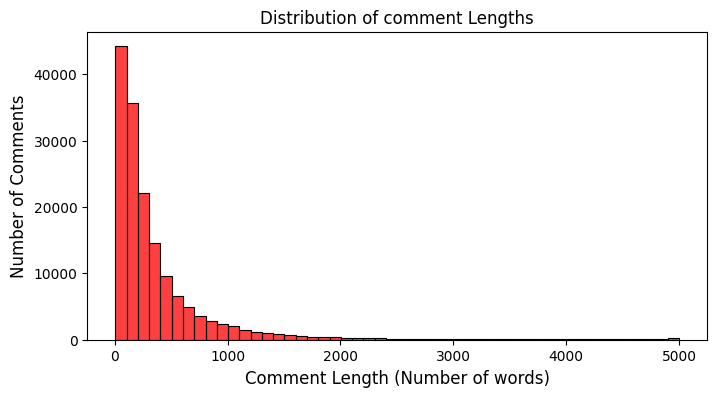

In [8]:
plot_len_of_sentences(train_df.comment_text.str)

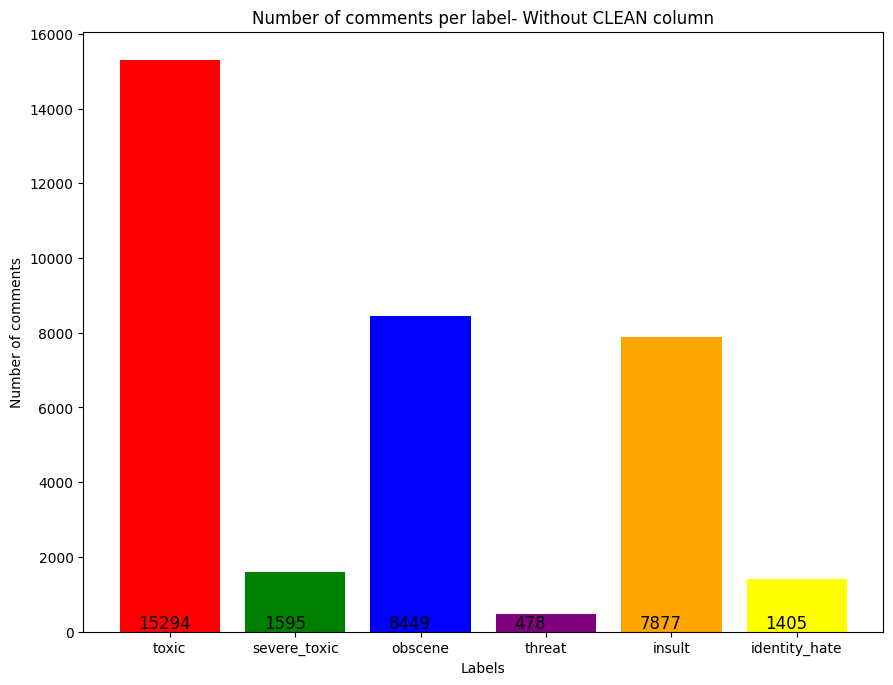

In [9]:
#Without clean Text
plot_bar_graph(train_df,labels[:-1],'Number of comments per label- Without CLEAN column')

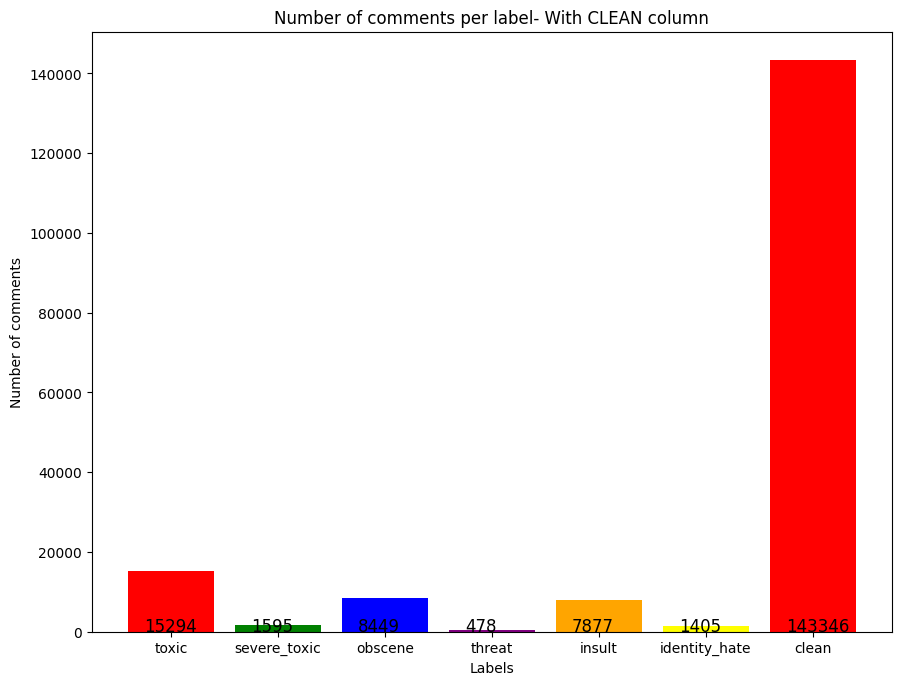

In [10]:
#With clean Text
plot_bar_graph(train_df,labels,'Number of comments per label- With CLEAN column')

In [11]:
train_df = preprocess_text(train_df)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,daww match background colour im seemingly stuc...,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,cant make real suggestion improvement wondered...,0,0,0,0,0,0,1
4,0001d958c54c6e35,sir hero chance remember page thats on,0,0,0,0,0,0,1


In [12]:
#Get sampled Data by removing Rows which create Bias
train_df = sample_dataset(train_df)
train_df.head()

<ipython-input-4-f5556fb22e81>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(train_df[train_df['clean']==1].sample(frac=1, random_state=200).iloc[:df.shape[0],:])


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
134065,cd04ee4935924644,got ill start on,0,0,0,0,0,0,1
128040,acd929b3f6c5984b,barnstar anti vandalism barnstar professing lo...,0,0,0,0,0,0,1
136471,da225210fb20b417,homey yo beat u up,0,0,0,1,0,0,0
112748,5b33d2be26a63953,encouraged feedback let clear bit first versio...,0,0,0,0,0,0,1
21589,38dd995c105311e6,shes insane zealot,1,0,0,0,1,0,0


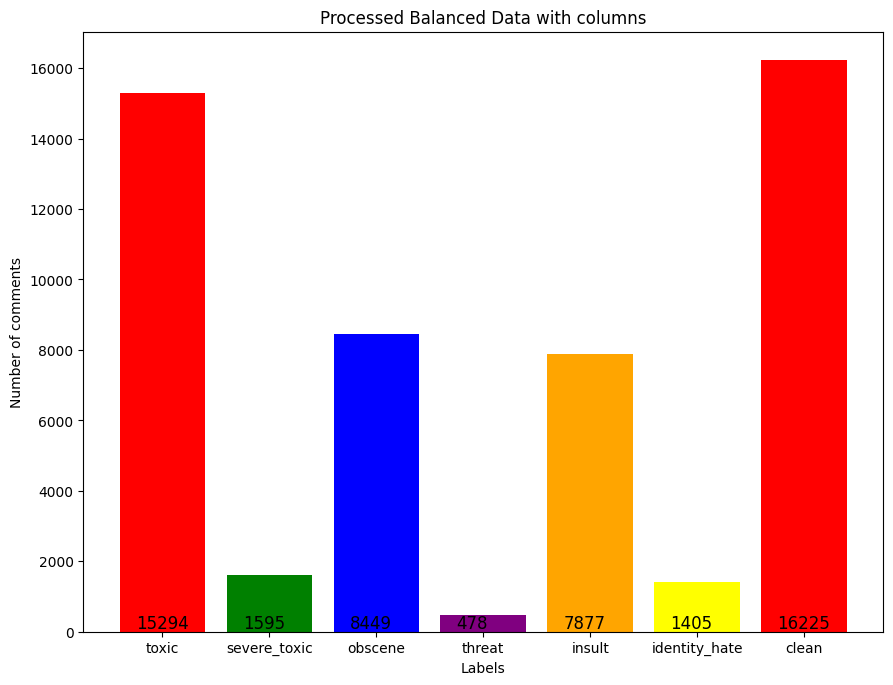

In [13]:
#modified dataset
plot_bar_graph(train_df,labels,'Processed Balanced Data with columns')

In [14]:
X = train_df['comment_text'].values
y = train_df.iloc[:,2:].values
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=200, stratify=y[:,-1])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(32450,) (32450, 7)
(25960,) (6490,) (25960, 7) (6490, 7)


In [15]:
ml_X_train, ml_X_test = baseline_ml_preprocessing(X_train,X_test)
print("X_train shape for baseline models:",ml_X_train.shape)
print("X_test shape for baseline models:",ml_X_test.shape)

X_train shape for baseline models: (25960, 3000)
X_test shape for baseline models: (6490, 3000)


## 4.0 CLASSICAL ML ALGORITHMS

We test the following algorithms -

*   Binary Relevance
*   Classifier Chain
*   One Vs Rest
*   Label PowerSet
*   Hierarchical SVM

In [16]:
class HierarchicalSVM:
    def __init__(self):
        self.classifiers = {}#Dictionary to store the classifiers for each label

    def train(self, X_train, Y_train):
        num_labels = Y_train.shape[1]
        # Train the classifiers for each label
        for label_idx in range(num_labels):
            label = str(label_idx)
            Y_label = Y_train[:, label_idx]
            classifier = SVC(kernel='linear')
            classifier.fit(X_train, Y_label)
            self.classifiers[label] = classifier

    def predict(self, X_test):
        num_labels = len(self.classifiers)
        num_samples = X_test.shape[0]
        predictions = np.zeros((num_samples, num_labels))
        for label_idx, classifier in self.classifiers.items():
            label_predictions = classifier.predict(X_test)
            predictions[:, int(label_idx)] = label_predictions
        return predictions

In [17]:
# Initialize an empty DataFrame for scores
scores_df = pd.DataFrame()

# Helper function to add results to the DataFrame
def add_to_scores_df(arr):
    global scores_df
    scores_df = pd.concat([scores_df, pd.DataFrame([arr])], ignore_index=True)


In [18]:
# Binary Relevance
print("====================BR============================")
model = BinaryRelevance(LogisticRegression(solver='sag'))
model.fit(ml_X_train, y_train[:,:-1])
y_pred = model.predict(ml_X_test)
arr = {'model_name':'BR',
       'micro_avg_f1_score':f1_score(y_test[:,:-1], y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test[:,:-1], y_pred),
       'accuracy':accuracy_score(y_test[:,:-1], y_pred)}
add_to_scores_df(arr)
print(classification_report(y_test[:,:-1], y_pred, zero_division=0))

# Classifier Chain
print("====================Classifier Chain============================")
model = ClassifierChain(LogisticRegression(solver='sag'))
model.fit(ml_X_train, y_train[:,:-1])
y_pred = model.predict(ml_X_test)
arr = {'model_name':'Classifier_Chain',
       'micro_avg_f1_score':f1_score(y_test[:,:-1], y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test[:,:-1], y_pred),
       'accuracy':accuracy_score(y_test[:,:-1], y_pred)}
add_to_scores_df(arr)
print(classification_report(y_test[:,:-1], y_pred, zero_division=0))

# One Vs Rest
print("====================One Vs Rest============================")
model = OneVsRestClassifier(LogisticRegression())
model.fit(ml_X_train, y_train[:,:-1])
y_pred = model.predict(ml_X_test)
arr = {'model_name':'One_vs_rest',
       'micro_avg_f1_score':f1_score(y_test[:,:-1], y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test[:,:-1], y_pred),
       'accuracy':accuracy_score(y_test[:,:-1], y_pred)}
add_to_scores_df(arr)
print(classification_report(y_test[:,:-1], y_pred, zero_division=0))

# Label Powerset
print("====================Label PowerSet============================")
model = LabelPowerset(LogisticRegression(max_iter=1000))
model.fit(ml_X_train, y_train[:,:-1])
y_pred = model.predict(ml_X_test)
arr = {'model_name':'Label_Powerset',
       'micro_avg_f1_score':f1_score(y_test[:,:-1], y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test[:,:-1], y_pred),
       'accuracy':accuracy_score(y_test[:,:-1], y_pred)}
add_to_scores_df(arr)
print(classification_report(y_test[:,:-1], y_pred, zero_division=0))

# Hierarchical SVM
print("====================Hierarchical SVM============================")
model = HierarchicalSVM()
model.train(ml_X_train, y_train[:,:-1])
y_pred = model.predict(ml_X_test)
arr = {'model_name':'Hierarchical_SVM',
       'micro_avg_f1_score':f1_score(y_test[:,:-1], y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test[:,:-1], y_pred),
       'accuracy':accuracy_score(y_test[:,:-1], y_pred)}
add_to_scores_df(arr)
print(classification_report(y_test[:,:-1], y_pred, zero_division=0))


====================BR============================
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      3049
           1       0.55      0.20      0.29       292
           2       0.88      0.69      0.78      1702
           3       0.71      0.11      0.19       107
           4       0.78      0.58      0.66      1564
           5       0.69      0.26      0.37       262

   micro avg       0.85      0.68      0.76      6976
   macro avg       0.75      0.45      0.53      6976
weighted avg       0.84      0.68      0.74      6976
 samples avg       0.37      0.33      0.34      6976

====================Classifier Chain============================
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      3049
           1       0.54      0.18      0.28       292
           2       0.87      0.72      0.79      1702
           3       0.69      0.10      0.18       107
           4    

In [19]:
scores_df

,model_name,micro_avg_f1_score,hamming_loss,accuracy
0,BR,0.759005,0.077838,0.661787
1,Classifier_Chain,0.764568,0.077607,0.668259
2,One_vs_rest,0.759005,0.077838,0.661787
3,Label_Powerset,0.722120,0.085362,0.653621
4,Hierarchical_SVM,0.775363,0.073523,0.671957


## 5.0 DATA PREPROCESSING FOR DEEP LEARNING

In [20]:
max_seq_len = 128
tokenizer, X_train, y_train, X_test, y_test = Sequential_Preprocessing(X_train, X_test, y_train, y_test,max_seq_len)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([25960, 128]) torch.Size([6490, 128]) torch.Size([25960, 7]) torch.Size([6490, 7])


In [21]:
glove_embeddings, glove_embedding_matrix = create_glove_embedding_matrix(tokenizer,glove_file_path='/content/drive/MyDrive/Colab Notebooks/CSC219-MachineLearning/finalproject/glove.6B/glove.6B.300d.txt')

GloVe embedding matrix created!
Vocabulary size: 50685
Total unknown words: 16419


In [22]:
glove_label_embeddings = create_glove_label_embedding(labels,glove_embeddings)
print(glove_label_embeddings.shape)

torch.Size([7, 300])


In [23]:
# word2vec_model = Word2Vec.load('path/to/word2vec_model')

# word2vec_embedding = {word: word2vec_model.wv[word] for word in word2vec_model.wv.vocab}

# # Define the vocabulary size and embedding dimensions
# vocab_size = len(tokenizer.index_word)+1
# embedding_dim = word2vec_model.vector_size

# # Create the embedding matrix
# word2vec_embedding_matrix = np.zeros((vocab_size, embedding_dim))
# for i, word in enumerate(word2vec_embedding):
#     word = tokenizer.index_word[i]
#     if word in word2vec_embedding.keys():
#       word2vec_embedding_matrix[i] = word2vec_embedding[word]
#     else:
#       continue
# print("Word2Vec Embedding matrix created!")
# print(word2vec_embedding_matrix.shape)

# word2vec_label_embedding = torch.zeros(len(labels),embedding_dim)

# for index, label in enumerate(labels):
#   wrds = label.split('_')
#   for l in wrds:
#     if l in word2vec_embedding.keys():
#         word2vec_label_embedding[index] +=  torch.from_numpy(word2vec_embedding[l])
#   word2vec_label_embedding[index]=word2vec_label_embedding[index]/len(wrds)

# print("Word2Vec label embedding:")
# print(word2vec_label_embedding)

In [23]:
bert_embeddding_matrix = get_bert_embedding_matrix(tokenizer)
print(bert_embeddding_matrix.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 99/99 [02:47<00:00,  1.70s/it]

torch.Size([50684, 768])


In [25]:
#Checking GPU for tensorflow
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# keras.backend.set_session(sess)
# print("GPU is Available? =>",tf.test.is_gpu_available())

In [24]:
VOCAB_SIZE = len(tokenizer.index_word)+1

#Preparing for KERAS Model
glove_embd_mat= np.array(glove_embedding_matrix.to('cpu'))
glove_embd_mat = np.vstack((np.zeros((1, glove_embd_mat.shape[1])), glove_embd_mat))
bert_embd_mat= np.array(bert_embeddding_matrix.to('cpu').detach().numpy())
bert_embd_mat = np.vstack((np.zeros((1, bert_embd_mat.shape[1])), bert_embd_mat))

## 6.0 DEEP LEARNING ALGORITHMS

* BiLSTM using glove embeddings
* BiLSTM using BERT embeddings
* CNN using BERT embeddings
* CNN usin BERT embeddings

### 6.1 BiLSTM WITH GLOVE EMBEDDINGS

In [25]:
# GloVe BiLSTM Model
print("=====================Glove BiLSTM===========================")

inp = Input(shape=(max_seq_len,))
x = Embedding(VOCAB_SIZE+1, 300, weights=[glove_embd_mat])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train), np.asarray(y_train), batch_size=256, epochs=3)
y_pred = model.predict(np.asarray(X_test), batch_size=256, verbose=1)
y_pred = np.where(y_pred > 0.5, 1, 0)

arr = {'model_name':'BiLSTM_glove',
       'micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test, y_pred),
       'accuracy':accuracy_score(y_test, y_pred)}
add_to_scores_df(arr)
print(scores_df)
print(classification_report(y_test, y_pred, zero_division=0))


=====================Glove BiLSTM===========================


Epoch 1/3
102/102 [==============================] - 115s 1s/step - loss: 0.3821 - accuracy: 0.6407
Epoch 2/3
102/102 [==============================] - 101s 991ms/step - loss: 0.2163 - accuracy: 0.8657
Epoch 3/3
26/26 [==============================] - 3s 91ms/step
         model_name  micro_avg_f1_score  hamming_loss  accuracy
0                BR            0.759005      0.077838  0.661787
1  Classifier_Chain            0.764568      0.077607  0.668259
2       One_vs_rest            0.759005      0.077838  0.661787
3    Label_Powerset            0.722120      0.085362  0.653621
4  Hierarchical_SVM            0.775363      0.073523  0.671957
5      BiLSTM_glove            0.829591      0.075501  0.671957
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      3049
           1       0.64      0.20      0.31       292
           2       0.81      0.83      0.82      1702
           3       0.00      0.00      0.00       107
           4  

### 6.2 BiLSTM WITH BERT EMBEDDINGS

In [26]:
# Bert BiLSTM Model
print("=====================Bert BiLSTM===========================")

inp = Input(shape=(max_seq_len,))
x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train), np.asarray(y_train), batch_size=256, epochs=4)
y_pred = model.predict(np.asarray(X_test), batch_size=256, verbose=1)
y_pred = np.where(y_pred > 0.5, 1, 0)

arr = {'model_name':'BiLSTM_bert',
       'micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test, y_pred),
       'accuracy':accuracy_score(y_test, y_pred)}
add_to_scores_df(arr)
print(scores_df)
print(classification_report(y_test, y_pred, zero_division=0))


=====================Bert BiLSTM===========================


Epoch 1/4
102/102 [==============================] - 106s 975ms/step - loss: 0.4059 - accuracy: 0.6156
Epoch 2/4
102/102 [==============================] - 98s 959ms/step - loss: 0.2359 - accuracy: 0.8564
Epoch 3/4
102/102 [==============================] - 97s 952ms/step - loss: 0.1842 - accuracy: 0.9038
Epoch 4/4
26/26 [==============================] - 2s 78ms/step
         model_name  micro_avg_f1_score  hamming_loss  accuracy
0                BR            0.759005      0.077838  0.661787
1  Classifier_Chain            0.764568      0.077607  0.668259
2       One_vs_rest            0.759005      0.077838  0.661787
3    Label_Powerset            0.722120      0.085362  0.653621
4  Hierarchical_SVM            0.775363      0.073523  0.671957
5      BiLSTM_glove            0.829591      0.075501  0.671957
6       BiLSTM_bert            0.831152      0.074686  0.666564
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3049
        

### 6.3 CNN WITH GLOVE EMBEDDINGS

In [27]:
# Glove CNN Model
print("=====================Glove CNN===========================")

inp = Input(shape=(max_seq_len,))
x = Embedding(VOCAB_SIZE+1, 300, weights=[glove_embd_mat])(inp)
x = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train), np.asarray(y_train), batch_size=256, epochs=3)
y_pred = model.predict(np.asarray(X_test), batch_size=256, verbose=1)
y_pred = np.where(y_pred > 0.5, 1, 0)

arr = {'model_name':'CNN_glove',
       'micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test, y_pred),
       'accuracy':accuracy_score(y_test, y_pred)}
add_to_scores_df(arr)
print(scores_df)
print(classification_report(y_test, y_pred, zero_division=0))

=====================Glove CNN===========================
Epoch 1/3
102/102 [==============================] - 20s 156ms/step - loss: 0.3606 - accuracy: 0.6747
Epoch 2/3
102/102 [==============================] - 10s 103ms/step - loss: 0.2040 - accuracy: 0.8718
Epoch 3/3
26/26 [==============================] - 0s 5ms/step
         model_name  micro_avg_f1_score  hamming_loss  accuracy
0                BR            0.759005      0.077838  0.661787
1  Classifier_Chain            0.764568      0.077607  0.668259
2       One_vs_rest            0.759005      0.077838  0.661787
3    Label_Powerset            0.722120      0.085362  0.653621
4  Hierarchical_SVM            0.775363      0.073523  0.671957
5      BiLSTM_glove            0.829591      0.075501  0.671957
6       BiLSTM_bert            0.831152      0.074686  0.666564
7         CNN_glove            0.819811      0.078560  0.657319
              precision    recall  f1-score   support

           0       0.87      0.88      0.88 

### 6.4 CNN WITH BERT EMBEDDINGS

In [28]:
# Bert CNN Model
print("=====================Bert CNN===========================")

inp = Input(shape=(max_seq_len,))
x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train), np.asarray(y_train), batch_size=256, epochs=3)
y_pred = model.predict(np.asarray(X_test), batch_size=256, verbose=1)
y_pred = np.where(y_pred > 0.5, 1, 0)

arr = {'model_name':'CNN_bert',
       'micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test, y_pred),
       'accuracy':accuracy_score(y_test, y_pred)}
add_to_scores_df(arr)
print(scores_df)
print(classification_report(y_test, y_pred, zero_division=0))

=====================Bert CNN===========================
Epoch 1/3
102/102 [==============================] - 15s 127ms/step - loss: 0.4232 - accuracy: 0.5701
Epoch 2/3
102/102 [==============================] - 10s 96ms/step - loss: 0.2407 - accuracy: 0.8375
Epoch 3/3
26/26 [==============================] - 0s 8ms/step
         model_name  micro_avg_f1_score  hamming_loss  accuracy
0                BR            0.759005      0.077838  0.661787
1  Classifier_Chain            0.764568      0.077607  0.668259
2       One_vs_rest            0.759005      0.077838  0.661787
3    Label_Powerset            0.722120      0.085362  0.653621
4  Hierarchical_SVM            0.775363      0.073523  0.671957
5      BiLSTM_glove            0.829591      0.075501  0.671957
6       BiLSTM_bert            0.831152      0.074686  0.666564
7         CNN_glove            0.819811      0.078560  0.657319
8          CNN_bert            0.822574      0.077438  0.660863
              precision    recall  f1

In [29]:
scores_df

,model_name,micro_avg_f1_score,hamming_loss,accuracy
0,BR,0.759005,0.077838,0.661787
1,Classifier_Chain,0.764568,0.077607,0.668259
2,One_vs_rest,0.759005,0.077838,0.661787
3,Label_Powerset,0.722120,0.085362,0.653621
4,Hierarchical_SVM,0.775363,0.073523,0.671957
5,BiLSTM_glove,0.829591,0.075501,0.671957
6,BiLSTM_bert,0.831152,0.074686,0.666564
7,CNN_glove,0.819811,0.078560,0.657319
8,CNN_bert,0.822574,0.077438,0.660863


### 7.0 MAGNET MODEL

In [30]:
def train(model, X_train, label_embedding, y_train,
          total_epoch=25, batch_size=32, learning_rate=0.001,
          save_path='./model.pt', state=None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    label_embedding = label_embedding.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_data = DataLoader(dataset(X_train, y_train), batch_size=batch_size)

    best_loss = float('inf')
    num_increasing_epochs = 0

    for epoch in range(1, total_epoch + 1):
        running_loss = 0
        y_pred = []
        epoch_time = 0
        model.train()

        for index, (X, y) in enumerate(train_data):
            optimizer.zero_grad()
            out = model(X.to(device), label_embedding)
            loss = criterion(out, y.to(device).float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            y_pred.append(torch.sigmoid(out.detach()).round().cpu())
            running_loss += loss.item()

        y_pred = torch.vstack(y_pred)
        f1score = f1_score(y_train, y_pred, average='micro')
        hammingloss = hamming_loss(y_train, y_pred)
        print(f'epoch:{epoch} loss:{running_loss:.5f} hamming_loss:{hammingloss:.5f} micro_f1score:{f1score:.5f}')

In [31]:
class MAGNET(nn.Module):
  def __init__(self, input_size, hidden_size, adjacency, embeddings, heads=4, slope=0.01, dropout=0.5):
    super(MAGNET, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embeddings)
    self.biLSTM = nn.LSTM(input_size,hidden_size,batch_first=True,bidirectional=True)
    self.adjacency = nn.Parameter(adjacency)
    self.dropout = nn.Dropout(dropout)
    self.edge_weights = nn.Linear(hidden_size*2*2, 1, bias=False)
    self.activation = nn.LeakyReLU(slope)
    self.softmax = nn.Softmax(dim=1)
    self.tanh = nn.Tanh()
    self.heads = heads
    self.transform_dim1 = nn.Linear(input_size, hidden_size*2, bias=False)
    self.transform_dim2 = nn.Linear(hidden_size*2, hidden_size*2, bias=False)
    self.transform_dimensions = [self.transform_dim1, self.transform_dim2]

  def forward(self, token, label_embedding):
      #BILSTM part
      features = self.embedding(token)
      out, (h, _) = self.biLSTM(features)
      embedding = torch.cat([h[-2, :, :], h[-1, :, :]], dim=1)
      embedding = self.dropout(embedding)

      #GAT PART
      for td in self.transform_dimensions: #Two Multiheaded GAT layers
        outputs = []
        for head in range(self.heads):
          label_embed = td(label_embedding)
          n, embed_size = label_embed.shape

          label_embed_combinations = label_embed.unsqueeze(1).expand(-1, n, -1)
          label_embed_combinations = torch.cat([label_embed_combinations, label_embed.unsqueeze(0).expand(n, -1, -1)], dim=2)
          e = self.activation(self.edge_weights(label_embed_combinations).squeeze(2))

          attention_coefficients = self.tanh(torch.mul(e,self.adjacency))

          new_h = torch.matmul(attention_coefficients.to(label_embed.dtype), label_embed)
          outputs.append(new_h)
        outputs = self.activation(torch.mean(torch.stack(outputs, dim=0),dim=0))

        label_embedding = outputs
      attention_features = self.dropout(label_embedding)
      attention_features = attention_features.transpose(0, 1)
      predicted_labels = torch.matmul(embedding, attention_features)
      return predicted_labels

In [32]:
save_path = '/content/drive/MyDrive/Colab Notebooks/CSC219-MachineLearning/finalproject/glove_magnet_model.pth'

### 7.1 INITIALIZAATION USING COOCCURANCE MATRIX

In [33]:
adj_matrix = create_adjacency_matrix_cooccurance(y_train.numpy())
adj_matrix = torch.tensor(adj_matrix)
adj_matrix

tensor([[1.0000, 0.1064, 0.5177, 0.0284, 0.4815, 0.0860, 0.0000],
        [1.0000, 1.0000, 0.9509, 0.0675, 0.8611, 0.1972, 0.0000],
        [0.9395, 0.1836, 1.0000, 0.0350, 0.7304, 0.1226, 0.0000],
        [0.9380, 0.2372, 0.6361, 1.0000, 0.6577, 0.2022, 0.0000],
        [0.9339, 0.1777, 0.7806, 0.0387, 1.0000, 0.1481, 0.0000],
        [0.9213, 0.2248, 0.7235, 0.0656, 0.8180, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]],
       dtype=torch.float64)

In [34]:
model = MAGNET(300, 250, adj_matrix, glove_embedding_matrix,heads=8)

In [35]:
#Coocurance initialization
train(model, X_train, glove_label_embeddings,y_train,total_epoch=5, save_path=save_path)

epoch:1 loss:230.16365 hamming_loss:0.11704 micro_f1score:0.71526
epoch:2 loss:181.43459 hamming_loss:0.08906 micro_f1score:0.79239
epoch:3 loss:169.00223 hamming_loss:0.08387 micro_f1score:0.80504
epoch:4 loss:157.25156 hamming_loss:0.07851 micro_f1score:0.81828
epoch:5 loss:147.98109 hamming_loss:0.07471 micro_f1score:0.82769


In [36]:
torch.save(model,save_path)

In [37]:
y_pred = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in tqdm(range(X_test.shape[0])):
  x = X_test[i].view(1,128)
  out = model(x.to(device), glove_label_embeddings.to(device))
  y_pred.append(torch.sigmoid(out.detach()).round().cpu())

100%|██████████| 6490/6490 [00:59<00:00, 109.25it/s]


In [38]:
y_pred = torch.vstack(y_pred)

In [39]:
# Add MAGNET_Cooccurance model's metrics to scores_df
arr = {'model_name':'MAGNET_Cooccurance',
       'micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test, y_pred),
       'accuracy':accuracy_score(y_test, y_pred)}
add_to_scores_df(arr)

print(arr)
print(classification_report(y_test, y_pred, zero_division=0))


{'model_name': 'MAGNET_Cooccurance', 'micro_avg_f1_score': 0.8086223433792721, 'hamming_loss': 0.0834470614131631, 'accuracy': 0.6325115562403698}
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3049
           1       0.50      0.16      0.25       292
           2       0.80      0.78      0.79      1702
           3       0.50      0.03      0.05       107
           4       0.70      0.66      0.68      1564
           5       0.30      0.03      0.05       262
           6       0.90      0.90      0.90      3245

   micro avg       0.84      0.78      0.81     10221
   macro avg       0.65      0.49      0.51     10221
weighted avg       0.81      0.78      0.79     10221
 samples avg       0.82      0.81      0.80     10221



### 7.2 XAVIOUR'S INITIALIZATION

In [40]:
adj_matrix = create_adjacency_matrix_xavier(y_train.numpy())
adj_matrix = torch.tensor(adj_matrix)
adj_matrix

<ipython-input-40-f66315f0aa9a>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_matrix = torch.tensor(adj_matrix)


tensor([[ 0.0425,  0.1248, -0.0656,  0.0393, -0.4935,  0.4509, -0.4365],
        [ 0.4097, -0.0731, -0.4270, -0.1459, -0.3945, -0.3495,  0.2812],
        [ 0.2756, -0.1357, -0.0649, -0.3128, -0.2103,  0.1339, -0.0396],
        [-0.0254, -0.4783, -0.3347,  0.2824,  0.3343, -0.5794,  0.4147],
        [-0.5876, -0.6126, -0.0403,  0.3601, -0.2609,  0.4159,  0.3111],
        [-0.1522,  0.2261, -0.4615,  0.1420,  0.4918, -0.2379,  0.6504],
        [-0.0023,  0.1162, -0.4116, -0.0315,  0.0024, -0.0761, -0.2447]])

In [41]:
model = MAGNET(300, 250, adj_matrix, glove_embedding_matrix,heads=8)

In [42]:
#Xavier Initialization
train(model, X_train, glove_label_embeddings,y_train,total_epoch=5, save_path=save_path)

epoch:1 loss:236.85727 hamming_loss:0.11876 micro_f1score:0.71477
epoch:2 loss:174.68720 hamming_loss:0.08535 micro_f1score:0.80254
epoch:3 loss:159.29678 hamming_loss:0.07913 micro_f1score:0.81828
epoch:4 loss:149.23303 hamming_loss:0.07483 micro_f1score:0.82890
epoch:5 loss:141.28225 hamming_loss:0.07080 micro_f1score:0.83846


In [43]:
y_pred = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in tqdm(range(X_test.shape[0])):
  x = X_test[i].view(1,128)
  out = model(x.to(device), glove_label_embeddings.to(device))
  y_pred.append(torch.sigmoid(out.detach()).round().cpu())

y_pred = torch.vstack(y_pred)

100%|██████████| 6490/6490 [00:54<00:00, 119.34it/s]


In [44]:
# Add MAGNET_xavier model's metrics to scores_df
arr = {'model_name':'MAGNET_xavier',
       'micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test, y_pred),
       'accuracy':accuracy_score(y_test, y_pred)}
add_to_scores_df(arr)

print(arr)
print(classification_report(y_test, y_pred, zero_division=0))


{'model_name': 'MAGNET_xavier', 'micro_avg_f1_score': 0.8228508924576143, 'hamming_loss': 0.07842835130970724, 'accuracy': 0.6405238828967642}
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3049
           1       0.52      0.12      0.19       292
           2       0.83      0.79      0.81      1702
           3       0.64      0.07      0.12       107
           4       0.68      0.74      0.71      1564
           5       0.59      0.35      0.44       262
           6       0.92      0.89      0.90      3245

   micro avg       0.84      0.81      0.82     10221
   macro avg       0.72      0.55      0.58     10221
weighted avg       0.83      0.81      0.81     10221
 samples avg       0.82      0.83      0.81     10221



### 7.3 RANDOM INITIALIZATION

In [45]:
#Random initialisation
adj_matrix = torch.randn(7, 7)

In [46]:
model = MAGNET(300, 250, adj_matrix, glove_embedding_matrix,heads=8)

In [47]:
#Random initialisation
train(model, X_train, glove_label_embeddings,y_train,total_epoch=5, save_path=save_path)

epoch:1 loss:239.34337 hamming_loss:0.12368 micro_f1score:0.69272
epoch:2 loss:180.03045 hamming_loss:0.08915 micro_f1score:0.79337
epoch:3 loss:163.20283 hamming_loss:0.08186 micro_f1score:0.81119
epoch:4 loss:152.42160 hamming_loss:0.07605 micro_f1score:0.82598
epoch:5 loss:143.59523 hamming_loss:0.07223 micro_f1score:0.83509


In [48]:
y_pred = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in tqdm(range(X_test.shape[0])):
  x = X_test[i].view(1,128)
  out = model(x.to(device), glove_label_embeddings.to(device))
  y_pred.append(torch.sigmoid(out.detach()).round().cpu())

y_pred = torch.vstack(y_pred)

100%|██████████| 6490/6490 [00:53<00:00, 120.27it/s]


In [49]:
# Add MAGNET_random model's metrics to scores_df
arr = {'model_name':'MAGNET_random',
       'micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test, y_pred),
       'accuracy':accuracy_score(y_test, y_pred)}
add_to_scores_df(arr)

print(arr)
print(classification_report(y_test, y_pred, zero_division=0))


{'model_name': 'MAGNET_random', 'micro_avg_f1_score': 0.7896186440677966, 'hamming_loss': 0.08743121285494167, 'accuracy': 0.5728813559322034}
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      3049
           1       0.42      0.11      0.18       292
           2       0.83      0.74      0.78      1702
           3       0.52      0.10      0.17       107
           4       0.70      0.64      0.67      1564
           5       0.40      0.16      0.23       262
           6       0.94      0.86      0.90      3245

   micro avg       0.86      0.73      0.79     10221
   macro avg       0.67      0.48      0.54     10221
weighted avg       0.84      0.73      0.78     10221
 samples avg       0.75      0.74      0.73     10221



In [50]:
model.adjacency

Parameter containing:
tensor([[-1.0689e-01,  5.2922e-01, -7.0251e-01, -1.4543e-01,  1.5937e-01,
         -6.7774e-01,  2.9772e-01],
        [-7.6412e-01,  1.3828e-01,  1.3861e+00, -4.1646e-02,  3.1467e+00,
          9.7962e-02,  1.9256e+00],
        [-1.9199e+00, -1.0415e-01,  1.1588e-01, -2.6981e+00, -7.7209e-02,
          9.2661e-01,  1.0843e+00],
        [-4.7895e-01,  2.3933e-01,  1.8989e+00, -1.3927e+00, -4.4514e-01,
         -1.0071e+00,  2.0935e-01],
        [-1.4743e-03,  4.5981e-01, -1.5219e-01, -1.8162e-01, -7.0027e-01,
         -1.1385e-01, -1.4339e+00],
        [ 1.2844e+00, -8.0087e-01, -1.0513e-01,  2.7592e-01,  1.5012e+00,
          5.2913e-01,  8.6267e-01],
        [ 4.1611e-01,  1.1396e-01,  9.9522e-01,  1.7657e-01, -3.3140e-01,
         -3.5377e-01, -9.1919e-01]], device='cuda:0', requires_grad=True)

In [51]:
new_h = model.adjacency @ glove_label_embeddings.to(device).float()

### 7.4 OBSERVATION

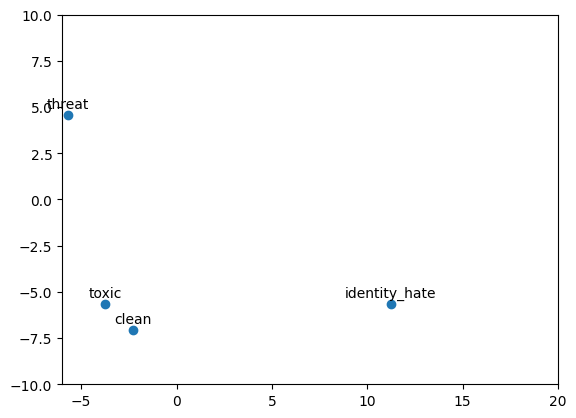

In [52]:
from sklearn.decomposition import PCA
pca = PCA(2)
Xt = pca.fit_transform(new_h.cpu().detach().numpy())
plot = plt.scatter(Xt[:,0], Xt[:,1])
for i, label in enumerate(labels):
    plt.annotate(label, (Xt[i][0], Xt[i][1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.xlim(-6, 20)
plt.ylim(-10, 10)
plt.show()

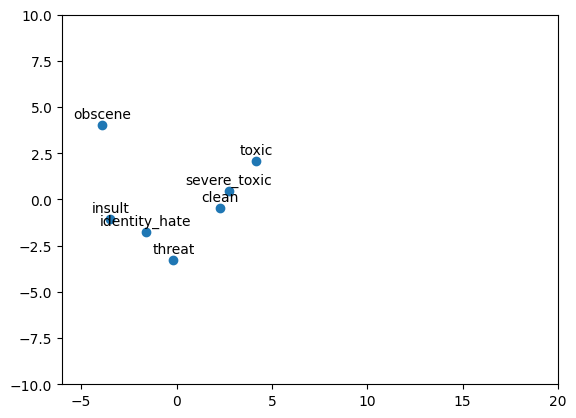

In [53]:
from sklearn.decomposition import PCA
pca = PCA(2)
Xt = pca.fit_transform(glove_label_embeddings)
plot = plt.scatter(Xt[:,0], Xt[:,1])
for i, label in enumerate(labels):
    plt.annotate(label, (Xt[i][0], Xt[i][1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.xlim(-6, 20)
plt.ylim(-10, 10)
plt.show()

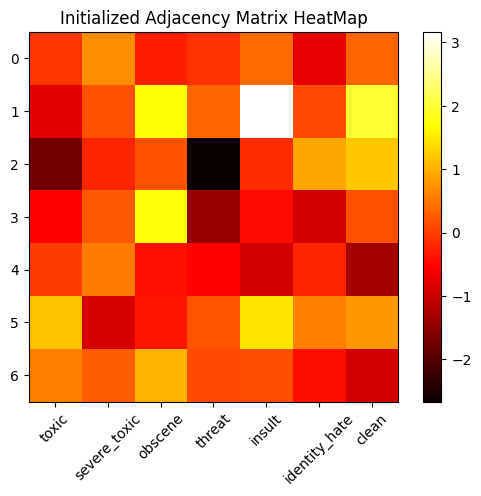

In [54]:
plt.imshow(adj_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.title('Initialized Adjacency Matrix HeatMap')
plt.show()

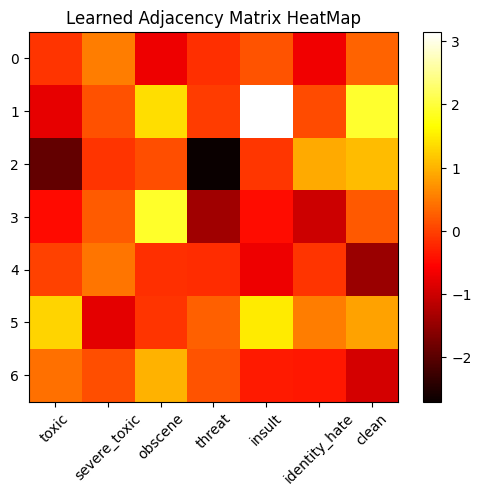

In [55]:
plt.imshow(model.adjacency.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.title('Learned Adjacency Matrix HeatMap')
plt.show()

In [56]:
scores_df

,model_name,micro_avg_f1_score,hamming_loss,accuracy
0,BR,0.759005,0.077838,0.661787
1,Classifier_Chain,0.764568,0.077607,0.668259
2,One_vs_rest,0.759005,0.077838,0.661787
3,Label_Powerset,0.722120,0.085362,0.653621
4,Hierarchical_SVM,0.775363,0.073523,0.671957
5,BiLSTM_glove,0.829591,0.075501,0.671957
6,BiLSTM_bert,0.831152,0.074686,0.666564
7,CNN_glove,0.819811,0.078560,0.657319
8,CNN_bert,0.822574,0.077438,0.660863
9,MAGNET_Cooccurance,0.808622,0.083447,0.632512


## 8.0 BERT MODEL

In [74]:
#train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSC219-MachineLearning/finalproject/jigsaw-toxic-comment-classification-challenge/train.csv')

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSC219-MachineLearning/finalproject/train_bert.csv')

print("Data shape:",train_df.shape)
#assigning labels

#Adding new column of Clean Text
arr=[]
for i in range(train_df.shape[0]):
  if (train_df.iloc[i,2:]==0).all():
    arr.append(1)
  else:
    arr.append(0)
train_df['clean'] = pd.Series(np.asarray(arr))
labels = train_df.columns[2:]
print("Labels:",labels)

Data shape: (127650, 8)
Labels: Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'clean'],
      dtype='object')


In [75]:
train_df = preprocess_text(train_df)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,daww match background colour im seemingly stuc...,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,cant make real suggestion improvement wondered...,0,0,0,0,0,0,1
4,0001d958c54c6e35,sir hero chance remember page thats on,0,0,0,0,0,0,1


In [76]:
#Get sampled Data by removing Rows which create Bias
train_df = sample_dataset(train_df)
train_df.head()

<ipython-input-4-f5556fb22e81>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(train_df[train_df['clean']==1].sample(frac=1, random_state=200).iloc[:df.shape[0],:])


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
78838,d2f64fa6a9a2f332,fuck dare rsvp bitch thought something im best...,1,1,1,0,1,0,0
121167,8841f41306f43817,someone totally wronged bullshit managed get s...,1,0,0,0,0,0,0
117849,75864f66dc6780c8,whats problem man hello sir request perform fe...,1,0,0,0,0,0,0
79153,d3dc0f6acaf9e9f1,edison edison people might interested determin...,0,0,0,0,0,0,1
57582,9a0fe2c95dbf8814,know still working watchlist change made artic...,0,0,0,0,0,0,1


In [77]:
device = torch.device('cuda')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [78]:
train_df, test_df = train_test_split(train_df, test_size=0.2,random_state=200,stratify=train_df.iloc[:,-1])

In [79]:
class ToxicDataset(Dataset):

    def __init__(self, tokenizer: BertTokenizer, dataframe: pd.DataFrame, lazy: bool = False):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.lazy = lazy
        if not self.lazy:
            self.X = []
            self.Y = []
            for i, (row) in tqdm(dataframe.iterrows()):
                x, y = self.row_to_tensor(self.tokenizer, row)
                self.X.append(x)
                self.Y.append(y)
        else:
            self.df = dataframe

    @staticmethod
    def row_to_tensor(tokenizer: BertTokenizer, row: pd.Series) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens = tokenizer.encode(row["comment_text"], add_special_tokens=True)
        if len(tokens) > 120:
            tokens = tokens[:119] + [tokens[-1]]
        x = torch.LongTensor(tokens)
        y = torch.FloatTensor(row[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate","clean"]])
        return x, y


    def __len__(self):
        if self.lazy:
            return len(self.df)
        else:
            return len(self.X)

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        if not self.lazy:
            return self.X[index], self.Y[index]
        else:
            return self.row_to_tensor(self.tokenizer, self.df.iloc[index])


def collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]], device: torch.device) \
        -> Tuple[torch.LongTensor, torch.LongTensor]:
    x, y = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = torch.stack(y)
    return x.to(device), y.to(device)

In [80]:
train_dataset = ToxicDataset(tokenizer, train_df, lazy=True)
test_dataset = ToxicDataset(tokenizer, test_df, lazy=True)
collate_fn = partial(collate_fn, device=device)
BATCH_SIZE = 32
train_sampler = RandomSampler(train_dataset)
dev_sampler = RandomSampler(test_dataset)
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
dev_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=dev_sampler, collate_fn=collate_fn)

In [81]:
class BertClassifier(nn.Module):

    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,

            labels=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1] # batch, hidden
        cls_output = self.classifier(cls_output) # batch, 6
        cls_output = torch.sigmoid(cls_output)
        criterion = nn.BCELoss()
        loss = 0
        if labels is not None:
            loss = criterion(cls_output, labels)
        return loss, cls_output

In [82]:
def train(model, iterator, optimizer, scheduler):
    model.train()
    total_loss = 0
    for x, y in tqdm(iterator):
        optimizer.zero_grad()
        mask = (x != 0).float()
        loss, outputs = model(x, attention_mask=mask, labels=y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Train loss {total_loss / len(iterator)}")

In [83]:
! nvidia-smi

Wed Jan 17 06:37:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              40W / 300W |   5616MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [84]:
! nvidia-smi -c 0

Compute mode is already set to DEFAULT for GPU 00000000:00:04.0.
All done.


In [85]:
model = BertClassifier(BertModel.from_pretrained('bert-base-uncased'), 7).to(device)

In [86]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
{'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
EPOCH_NUM = 8
# triangular learning rate, linearly grows untill half of first epoch, then linearly decays
warmup_steps = 10 ** 3
total_steps = len(train_iterator) * EPOCH_NUM - warmup_steps
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [88]:
for i in range(EPOCH_NUM):
    print('=' * 50, f"EPOCH {i}", '=' * 50)
    train(model, train_iterator, optimizer, scheduler)
    # evaluate(model, dev_iterator)

================================================== EPOCH 0 ==================================================


100%|██████████| 650/650 [02:44<00:00,  3.96it/s]


Train loss 0.34720342830969736
================================================== EPOCH 1 ==================================================


100%|██████████| 650/650 [02:57<00:00,  3.66it/s]


Train loss 0.1751479036303667
================================================== EPOCH 2 ==================================================


100%|██████████| 650/650 [02:44<00:00,  3.96it/s]


Train loss 0.13835337535693096
================================================== EPOCH 3 ==================================================


100%|██████████| 650/650 [02:44<00:00,  3.96it/s]


Train loss 0.11409612508347401
================================================== EPOCH 4 ==================================================


100%|██████████| 650/650 [02:44<00:00,  3.95it/s]


Train loss 0.0976548279907841
================================================== EPOCH 5 ==================================================


100%|██████████| 650/650 [02:44<00:00,  3.95it/s]


Train loss 0.08546678413851903
================================================== EPOCH 6 ==================================================


100%|██████████| 650/650 [02:44<00:00,  3.94it/s]


Train loss 0.07837462589717828
================================================== EPOCH 7 ==================================================


100%|██████████| 650/650 [02:44<00:00,  3.94it/s]

Train loss 0.07776357826991723


In [89]:
model.eval()
y_pred=[]
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean']
for i in tqdm(range(len(test_df) // BATCH_SIZE + 1)):
    batch_df = test_df.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
    texts = []
    for text in batch_df["comment_text"].tolist():
        text = tokenizer.encode(text, add_special_tokens=True)
        if len(text) > 120:
            text = text[:119] + [tokenizer.sep_token_id]
        texts.append(torch.LongTensor(text))
    x = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    mask = (x != tokenizer.pad_token_id).float().to(device)
    with torch.no_grad():
        _, outputs = model(x, attention_mask=mask)
    outputs = outputs.cpu().numpy()
    y_pred.append(outputs)

100%|██████████| 163/163 [00:16<00:00,  9.96it/s]


In [90]:
y_pred = np.vstack(np.asarray(y_pred))

<ipython-input-90-c5eb8d659cd7>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred = np.vstack(np.asarray(y_pred))


In [91]:
y_pred = np.where(y_pred>0.5,1,0)

In [92]:
y_test = test_df.iloc[:,2:].values

In [93]:
# Add BERT model's metrics to scores_df
arr = {'model_name':'BERT',
       'micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),
       'hamming_loss':hamming_loss(y_test, y_pred),
       'accuracy':accuracy_score(y_test, y_pred)}
add_to_scores_df(arr)

print(arr)
print(classification_report(y_test, y_pred, zero_division=0))


{'model_name': 'BERT', 'micro_avg_f1_score': 0.8588079788512378, 'hamming_loss': 0.06456043956043957, 'accuracy': 0.6886538461538462}
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2447
           1       0.50      0.43      0.46       251
           2       0.84      0.86      0.85      1364
           3       0.51      0.44      0.47        68
           4       0.74      0.79      0.77      1294
           5       0.57      0.57      0.57       203
           6       0.95      0.92      0.93      2600

   micro avg       0.85      0.87      0.86      8227
   macro avg       0.71      0.71      0.71      8227
weighted avg       0.85      0.87      0.86      8227
 samples avg       0.86      0.87      0.85      8227



In [94]:
scores_df

,model_name,micro_avg_f1_score,hamming_loss,accuracy
0,BR,0.759005,0.077838,0.661787
1,Classifier_Chain,0.764568,0.077607,0.668259
2,One_vs_rest,0.759005,0.077838,0.661787
3,Label_Powerset,0.722120,0.085362,0.653621
4,Hierarchical_SVM,0.775363,0.073523,0.671957
5,BiLSTM_glove,0.829591,0.075501,0.671957
6,BiLSTM_bert,0.831152,0.074686,0.666564
7,CNN_glove,0.819811,0.078560,0.657319
8,CNN_bert,0.822574,0.077438,0.660863
9,MAGNET_Cooccurance,0.808622,0.083447,0.632512
